<a href="https://colab.research.google.com/github/shirart/data_science_proj_1/blob/main/data_science_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns  #boxplot
import matplotlib.pyplot as plt

data = pd.read_csv('sample_data/train-data.csv')
numeric_data = data.filter(items=['Year', 'Kilometers_Driven', 'Transmission', 'Mileage', 'Engine', 'Power', 'Seats', 'New_Price', 'Price'])

filtered_data = numeric_data.drop(['New_Price'], axis=1) # axis 0 = row (x) axis, axis 1 = row (y) axis

# remove units from data
filtered_data['Mileage'] = filtered_data['Mileage'].str.strip('km/kgpl ')
filtered_data['Engine'] = filtered_data['Engine'].str.strip('CC ')
filtered_data['Power'] = filtered_data['Power'].str.strip('bhp ')

filtered_data= filtered_data.replace("null", np.nan)

# removed high kilometers_driven values as it exceeded the standard range (over 1 milion)
filtered_data['Kilometers_Driven']=filtered_data['Kilometers_Driven'].where(filtered_data['Kilometers_Driven']<1*10**6)

filtered_data['Transmission'] = (filtered_data['Transmission'] == 'Manual')
filtered_data = filtered_data.astype(float)


In [14]:
filtered_data.isnull().sum() * 100 / len(filtered_data)

Year                 0.000000
Kilometers_Driven    0.016614
Transmission         0.000000
Mileage              0.033228
Engine               0.598106
Power                2.375810
Seats                0.697790
Price                0.000000
dtype: float64

In [15]:
filtered_data.describe()

,Year,Kilometers_Driven,Transmission,Mileage,Engine,Power,Seats,Price
count,6019.000000,6018.000000,6019.000000,6017.000000,5983.000000,5876.000000,5977.000000,6019.000000
mean,2013.358199,57668.047690,0.714238,18.134961,1621.276450,113.253050,5.278735,9.479468
std,3.269742,37878.783175,0.451814,4.582289,601.355233,53.874957,0.808840,11.187917
min,1998.000000,171.000000,0.000000,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,34000.000000,0.000000,15.170000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,53000.000000,1.000000,18.150000,1493.000000,97.700000,5.000000,5.640000
75%,2016.000000,73000.000000,1.000000,21.100000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,775000.000000,1.000000,33.540000,5998.000000,560.000000,10.000000,160.000000


In [ ]:
####################################################################################################################
# graphic presentation for each feature
####################################################################################################################

items=['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Transmission','Price']
fig, axes = plt.subplots(nrows=len(items), figsize=(15,40))
ranges = [None, [filtered_data['Kilometers_Driven'].min(), filtered_data['Kilometers_Driven'].max()], None, [0,5000], None, [0, 9], None,[0,80]]
for i in range(len(items)):
  _ = axes[i].hist(filtered_data[items[i]], bins=50,range=ranges[i])
  axes[i].set_title(items[i], fontsize=16)
  
plt.show()

In [ ]:
items=['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Transmission']
fig, axes = plt.subplots(nrows=len(items), figsize=(10,30))
ranges = [None, [filtered_data['Kilometers_Driven'].min(), filtered_data['Kilometers_Driven'].max()], None, None, None, [0, 9], None,None]
for i in range(len(items)):
  filtered_data.iloc[:,:-1].boxplot(column=[items[i]], ax=axes[i], fontsize = 16)

plt.show()

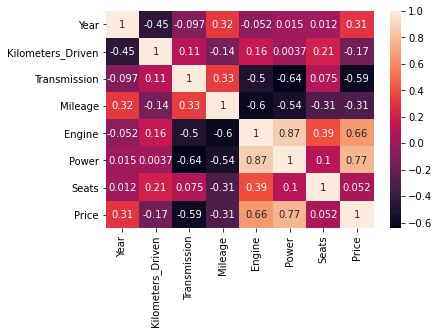

In [18]:
corr_matrix = filtered_data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from tqdm import tqdm
from scipy import stats

####################################################################################################################
#preparing data:
####################################################################################################################

# filter out NaN values
filtered_data = filtered_data.dropna()

#fill nan's with SimpleImputer
#imp=SimpleImputer(missing_values=np.nan, strategy='mean')
#imp.fit(filtered_data.iloc[:,:-1])
#data = pd.DataFrame(imp.transform(filtered_data.iloc[:,:-1]))

#fill nan's regarding to correlation
#engine_key=[]
# assert on engine - finding value for poweer due to engine

# split data 
X = filtered_data.iloc[:,:-1]  #iloc - get part of the columes (or rows)
y = filtered_data["Price"]

In [20]:
##########################################################################################
def k_fold_validator(regressor, X_train_val, y_train_val, k):
  return np.mean(cross_val_score(regressor, X_train_val, y_train_val, cv=k, n_jobs=-1, scoring='neg_mean_squared_error'))

def ten_fold_validator(regressor, X_train_val, y_train_val):
  return k_fold_validator(regressor, X_train_val, y_train_val, 10)

def llo_validator(regressor, X_train_val, y_train_val):
  return k_fold_validator(regressor, X_train_val, y_train_val, X_train_val.shape[0])

def holdout_validator(regressor, X_train_val, y_train_val):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)
  regressor.fit(X_train, y_train)
  return regressor.score(X_val, y_val)
##########################################################################################

def get_optimal_tree(X_train_val, X_test, y_train_val, y_test, validator_func):
  best_hyp = None
  best_score = None
  optimal_tree = None
  for max_depth in tqdm(range(5, 15)):
   for min_samples_split in range(2, 10):
    for min_samples_leaf in range(1, 5):
     for criterion in ('mse', 'friedman_mse', 'mae'):
       params = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}
       tree = DecisionTreeRegressor(**params)
       score = validator_func(tree, X_train_val, y_train_val)
       if best_score is None or score > best_score:
          best_hyp = params
          best_score = score
          optimal_tree = tree
  optimal_tree.fit(X_train_val, y_train_val)
  train_best_score =  optimal_tree.score(X_train_val, y_train_val)
  print(f'Best score wrt. training: { train_best_score}')
  best_score =  optimal_tree.score(X_test, y_test)
  print(f'Best score wrt. test: {best_score}')
  return optimal_tree, best_score, train_best_score, best_hyp
  


In [21]:
####################################################################################################################
#model 1 - DecisionTreeRegressor:
####################################################################################################################

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

validator_names = ["10 Fold", "Holdout"]
validators = [ten_fold_validator, holdout_validator]
optimal_trees = []
best_scores = []
train_best_scores = []
best_hyps = []

for i in range(len(validators)):
  print(f'Validating using {validator_names[i]}')
  optimal_tree, best_score, train_best_score, best_hyp = get_optimal_tree(X_train_val, X_test, y_train_val, y_test, validators[i])
  optimal_trees.append(optimal_tree)
  best_scores.append(best_score)
  train_best_scores.append(train_best_score)
  best_hyps.append(best_hyp)

best_score_index = np.argmax(best_scores)
optimal_tree = optimal_trees[best_score_index]
best_hyp = best_hyps[best_score_index]
print(f'Best params: {best_hyp}')

llo_score = llo_validator(DecisionTreeRegressor(**best_hyp), X_train_val, y_train_val)
print(f'LLO score: {llo_score}')


  0%|          | 0/10 [00:00<?, ?it/s]

Validating using 10 Fold


  0%|          | 0/10 [00:00<?, ?it/s]

Best score wrt. training: 0.9317938675565329
Best score wrt. test: 0.8363563778879973
Validating using Holdout


100%|██████████| 10/10 [03:01<00:00, 18.19s/it]


Best score wrt. training: 0.940730026956415
Best score wrt. test: 0.8877858865515847
Best params: {'criterion': 'friedman_mse', 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 9}
LLO score: -19.983759712107123


In [ ]:
import graphviz
from IPython.display import SVG, display

# first node corresponds to feature with highest correlation to price (the feature is: power)
graph = graphviz.Source(export_graphviz(optimal_tree))
display(SVG(graph.pipe(format='svg')))


In [22]:
####################################################################################################################
def get_optimal_ridge(X, y, validator_func):
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
  best_hyp = None
  best_score = None
  optimal_rid = None
  for alpha in tqdm(range(1, 1000, 100)):
       rid = Ridge(alpha=alpha/1000.0)
       score = validator_func(rid, X_train_val, y_train_val)
       if best_score is None or score > best_score:
          best_hyp = alpha/1000.0
          best_score = score
          optimal_rid = rid
  optimal_rid.fit(X_train_val, y_train_val)
  train_best_score =  optimal_rid.score(X_train_val, y_train_val)
  print(f'Best score wrt. training: {train_best_score}')
  best_score =  optimal_rid.score(X_test, y_test)
  print(f'Best score wrt. test: {best_score}')
  return optimal_rid, best_score, train_best_score, best_hyp, y_test, X_test

In [32]:
####################################################################################################################
#model 2 - Ridge:
####################################################################################################################

validator_names = ["10 Fold", "LLO", "Holdout"]
validators = [ten_fold_validator, llo_validator, holdout_validator]
optimal_ridges = []
best_scores_r = []
train_best_scores_r = []
best_hyps = []
for i in range(len(validators)):
  print(f'Validating using {validator_names[i]}')
  optimal_ridge, best_score, train_best_score, best_hyp_r, y_test_r, X_test_r = get_optimal_ridge(X, y, validators[i])
  optimal_ridges.append(optimal_ridge)
  best_scores_r.append(best_score)
  train_best_scores_r.append(train_best_score)
  best_hyps.append(best_hyp_r)

best_score_index = np.argmax(best_scores_r)
optimal_ridge = optimal_ridges[best_score_index]
best_hyp = best_hyps[best_score_index]
print(f'Best alpha: {best_hyp}')


  0%|          | 0/10 [00:00<?, ?it/s]

Validating using 10 Fold


  0%|          | 0/10 [00:00<?, ?it/s]

Best score wrt. training: 0.694067870867426
Best score wrt. test: 0.6744920390369478
Validating using LLO


100%|██████████| 10/10 [00:00<00:00, 207.69it/s]

Best score wrt. training: 0.694067870867426
Best score wrt. test: 0.6744920390369478
Validating using Holdout
Best score wrt. training: 0.694067870867426
Best score wrt. test: 0.6744920390369478
Best alpha: 0.901


In [24]:
####################################################################################################################
# mse - models:
####################################################################################################################

from sklearn.metrics import mean_squared_error

y_true = y_test
y_pred = optimal_tree.predict(X_test)

# compute mse manually
errors = y_pred-y_test
errors = [x**2 for x in errors]
mse = np.mean(errors)
print(mse)

# compute mse automatically (with sklearn)
mse = mean_squared_error(y_true, y_pred)
print(mse)

13.754195435147157
13.754195435147157


In [26]:
from sklearn.metrics import mean_squared_error
y_true_r = y_test_r
y_pred_r = optimal_ridge.predict(X_test_r)

mse_r = mean_squared_error(y_true_r , y_pred_r)
print(mse_r)

39.89783435610521


In [30]:
####################################################################################################################
# comparing models:
####################################################################################################################
from IPython.display import display, HTML

print("Train results:")
df = pd.DataFrame({"10-Fold": [train_best_scores[0], train_best_scores_r[0]], "LLO": [None, train_best_scores_r[1]], "Holdout": [train_best_scores[1], train_best_scores_r[2]]}, index=['Decision Tree Regressor', 'Ridge'])
display(HTML(df.to_html()))

# The MSE is computed with respect to the optimal hyper-parameters on the test set
print("Test results:")
df = pd.DataFrame({"10-Fold": [best_scores[0], best_scores_r[0]], "LLO": [None, best_scores_r[1]], "Holdout": [best_scores[1], best_scores_r[2]], "MSE": [mse, mse_r]}, index=['Decision Tree Regressor', 'Ridge'])
display(HTML(df.to_html()))


Train results:


,10-Fold,LLO,Holdout
Decision Tree Regressor,0.931794,NaN,0.940730
Ridge,0.694068,0.694068,0.694068


Test results:


,10-Fold,LLO,Holdout,MSE
Decision Tree Regressor,0.836356,NaN,0.887786,13.754195
Ridge,0.674492,0.674492,0.674492,39.897834
